In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from to_import import *

In [2]:
def str_to_bytearray(string_data):
    new_data = []
    for i in range(0, len(string_data), 8):
        new_data.append(string_data[i:i+8])  

    int_data = [] 
    for i in new_data:
        int_data.append(int(i,2))

    return bytearray(int_data)

In [3]:
with open('Data_Files/a7r56tu_knownseq.csv', 'r') as file:
    raw = file.read().replace('\n', ',').split(',')

known = []
for value in raw:
    try:
        v = float(value)
        if v == 0:
            symbol = cmath.exp((math.pi/4) * 1j)
        elif v ==1:
            symbol = cmath.exp((3*math.pi/4) * 1j)
        elif v == 2:
            symbol = cmath.exp((5*math.pi/4) * 1j)
        else:
            symbol = cmath.exp((7*math.pi/4) * 1j)
        

        known.append(symbol)
    except:
        pass
    
known = np.array(known)

In [4]:
first1024 = known[:1024]

first_half = []
for val in first1024:
    first_half.append(val)
    first_half.append(0)
first_half.pop()

SC_fourier = np.concatenate(([0], first_half, [0], np.conjugate(first_half[::-1])))
SC_time = ifft(SC_fourier).real

known_fourier = np.concatenate(([0], known, [0], np.conjugate(known[::-1])))
known_time = ifft(known_fourier).real

In [5]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(100,8000,1, volume = 100)
print(len(chirp_signal))

48000


In [6]:
y = audioDataFromFile('Data_Files/d1d76p_received.wav')

In [7]:
y_section = np.reshape(y, y.size)[0:200000]
g = np.convolve(y_section, chirp_signal[::-1], 'valid') # convoluton
i_max = np.argmax(g) # front chirp

# Don't really need these but yeah why not. 
y_section = np.reshape(y, y.size)[-200000:]
g_end = np.convolve(y_section, chirp_signal[::-1], 'valid') # convoluton
i_max_2 = np.argmax(g_end)
i_max_end = len(y) - 200000 + i_max_2

In [19]:
error = 1
y_confirm = y[i_max+ len(chirp_signal)+4096+100+error:]

dist = i_max_end - i_max - len(chirp_signal)
num_of_symbol = math.floor(dist/4196)
print(dist, num_of_symbol, dist - num_of_symbol*4196)


# start of second 100 symbols 
y_end_CE =  y[i_max + len(chirp_signal) + (num_of_symbol-101)*4196:]
print(len(chirp_signal) + (num_of_symbol-101)*4196)


# Distance from 50th CE symbol at start to 50th CE symbol at the end 
# Writing out full expression for clarity here
start = i_max + len(chirp_signal) + 4196 + 4196*50  #chirp start + chirp length + S&C + 50 symbols
end = i_max + len(chirp_signal) + (num_of_symbol-101)*4196 + 4196*50  # start of second 100 symbols + 50 symbols
distance = end - start

print("distance", distance)

shift = 100
CE_samples, CE_freq, remaining = sliceData(y_confirm, shift, 4096, 100, 100)
CE_samples_2, CE_freq_2, remaining_2 = sliceData(y_end_CE, shift, 4096, 100, 100)

3562410 849 6
3186608
distance 3134412


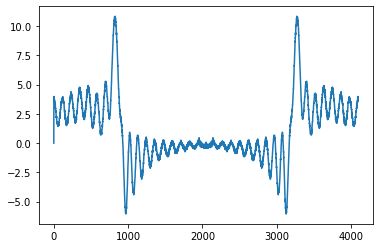

In [20]:
# getImpulseSimple(freq, known_freq, N, repeat)

#impulse_simple, TF = getImpulseSimple(CE_freq, known_fourier, len(CE_freq[0]), len(CE_freq))
#impulse_simple_2, TF_2 = getImpulseSimple(CE_freq_2, known_fourier, len(CE_freq_2[0]), len(CE_freq_2))

impulse_simple, TF = getImpulseSimple_time_avg(CE_samples, known_fourier, len(CE_samples[0]), len(CE_samples))
impulse_simple_2, TF_2 = getImpulseSimple_time_avg(CE_samples_2, known_fourier, len(CE_samples_2[0]), len(CE_samples_2))

plot_y(TF)
#plot_y(TF.imag)
#plot_y(np.angle(TF), f=1)

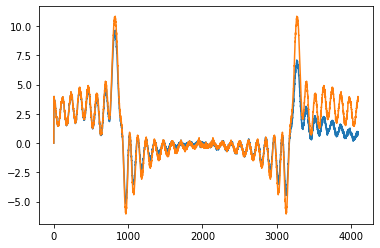

In [18]:
'''#def getImpulseSimple(freq, known_freq, N, repeat):
known_freq = known_fourier
N = 4096
repeat = 100


TF_adjust = np.zeros(N,dtype=complex)
for j, freq_response in enumerate(CE_freq):
    
    location = (j-repeat/2)*4196 + 2098
    offset = (location/distance) * 6
    
    for i in range(N):
        adjustment = cmath.exp((2*math.pi/4096)*offset*1j*i*-1)
         
        if i == int(N/2) or i == 0:
            TF_adjust[i] == 0
        else:
            div = (freq_response[i]/known_freq[i] ) * adjustment
            TF_adjust[i] += div 

TF_adjust = np.array([x/repeat for x in TF_adjust])

plot_y(TF_adjust)


impulse_simple, TF = getImpulseSimple(CE_freq, known_fourier, len(CE_freq[0]), len(CE_freq))

plot_y(TF)'''

[ 0.19133315  0.18194643  0.10795549  0.09053395  0.10860705  0.09993318
  0.07173981 -0.01176327 -0.00439165  0.00657889]
[-37.4509464  -37.46480475 -37.46695702 -37.5906218  -37.51888765
 -37.6111382  -37.60618927 -37.65219152 -37.65317777 -37.68441507]


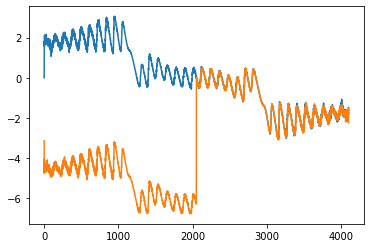

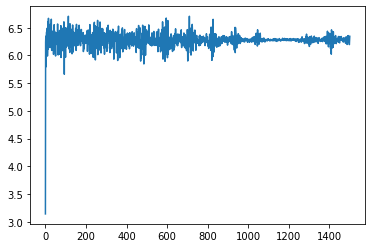

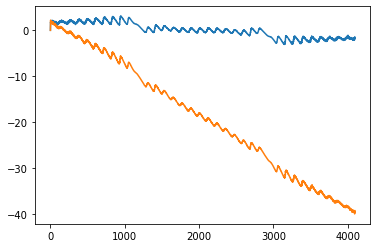

In [141]:
TF_shift = fft(np.roll(impulse_simple_2, -6))

print(np.unwrap(np.angle(TF))[-10:])
print(np.unwrap(np.angle(TF_2))[-10:])


plot_y(fftshift(np.unwrap(np.angle(TF))))
#plot_y(fftshift(np.unwrap(np.angle(TF_2))))
plot_y(fftshift(np.unwrap(np.angle(TF_shift))))

angle1 = fftshift(np.unwrap(np.angle(TF)))
angle2 = fftshift(np.unwrap(np.angle(TF_shift)))

diff = []
for i, val in enumerate(angle1):
    diff.append(val - angle2[i])

plot_y(diff[:1500], f=4)

plot_y(fftshift(np.angle(TF)), f=1)
plot_y(  np.unwrap(fftshift(np.angle(TF_2))), f=1)
#plot_y(  fftshift(np.angle(TF_2)), f=1)

In [23]:
y_data = y_confirm[4196*100:]

[0.        +0.j         3.87262977-0.02547796j 3.749005  +0.01646444j ...
 3.73390689-0.04392496j 3.749005  -0.01646444j 3.87262977+0.02547796j]


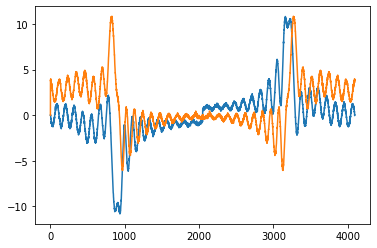

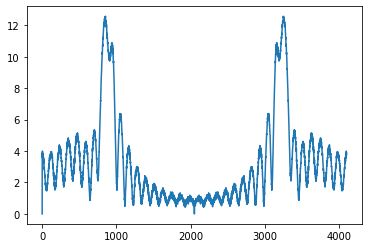

In [24]:
plot_y(TF.imag)
plot_y(TF.real)
plot_y(abs(TF), f =1)
print(TF)

In [25]:
d = len(y_data)/4196
print(d)
chunks = []
for i in range(math.floor(d)):
    chunks.append(y_data[i*4196:(i+1)*4196][shift:shift+4096])
    
print(len(chunks[0]))

766.2635843660629
4096


In [145]:
binary = []
freq = TF[1:2048]
for i in range(1): #len(chunks)):
    # Find what linear phase to multiply. 
    location = 50*4196 + i*4196 + 2098
    offset = (location/distance) * (6.25)

    #print("location", location, " offset", offset)

    fft_data = fft(np.roll(chunks[i],0))[1:2048]


    val = []
    for j in range(len(fft_data)):
        adjustment = cmath.exp((2*math.pi/4096)*offset*1j*j)

        div = (fft_data[j]/freq[j])* adjustment# * cmath.exp(j*1j)
        val.append(div)

        bit0 = 0
        bit1 = 0

        if div.real < 0:
            bit1 = 1
        if div.imag < 0:
            bit0 = 1

        binary.append(bit0)
        binary.append(bit1)


bin_single_sting = ""
for i in range(len(binary)):
    bin_single_sting += str(binary[i])

In [146]:
str_to_bytearray(bin_single_sting)[:3000].decode("utf-8", "replace")



'd1d76p.Wav\x0033\x10�:bhR\tFF�\x0b\x05\x00WAVEfmt \x10\x00\x00\x001\x00\x00\x00A7\x00\x00��\x00\x01\x02\x00\x10\x00dataz\x0b\x05\x00�@B\x01E\x01�\x00�\x00�\x01�\x00��s \x05\x01�\x01f\x01�\x00�\x00\x17\x01�\x00�\x00\x11\x01\x14A�\x02E\x00:\x00�\x00;\x00��6\x00/\x00������\x12\x00��������`�w)�������n�A���������J�l]���=��������������������������������\x1d\x00��\x00\x00��+\x005\x00-\x00 \x00\x05\x00I\x00V\x00h\x00j\x00H\x00*\x00#\x00\x00\x00i\x00t\x00|\x004\x00\x1d\x00����M\x00n\x00L\x11��\x1b\x00��0\x00+\x00!\x00������%\x00\x16\x00\x0b\x00\x1c\x06�������\x7f��\x15\x00��\x08\x00����������\x12\x00�n(�h������������\x05\x00��������Pz\x11�.�\x02@������;����������\x1f�7��.��v����������\x02\x06�2\x01S\x00��y\x18\x0c#x:�P�DP�>\x14-\x14T\x04M\x04_\x00(\x00+\x14K\x10uD\'�W\x02u\x04\x01\x18�&4T\x08q\x00\x05\x00"\x05r\x04U\x004\x11]\x03r{@�}\x04��\x10\x00�\x00�\x01����������\x03\x10��֯%/e��+��O��;�����\x7f��\x1e������*\x1e��ɻiV�-'

In [68]:
# Find information about the file name and the byte length of the file
file_seperation = []
count = 0
for i in range(math.floor(len(binary)/8)):
    byte = binary[i*8:(i+1)*8]
    zero = True
    for bit in byte:
        if bit == 1:
            zero = False
            
    if zero:
        #print(byte, "zero")
        file_seperation.append(i*8)
            
        count += 1
    
    if count == 2:
        break
        
print(file_seperation)
# Extract file name and length of the file
Filename= str_to_bytearray(bin_single_sting[0:file_seperation[0]]).decode("utf-8", "replace")
Length = int(str_to_bytearray(bin_single_sting[file_seperation[0]+8:file_seperation[1]]).decode("utf-8", "replace"))

extra_bits = len(binary) - file_seperation[1] - 8 - Length*8

raw_file = bin_single_sting[file_seperation[1] + 8 : -1*extra_bits]

print(Filename, Length, extra_bits)

[80, 200]


ValueError: invalid literal for int() with base 10: '330&rbhRAF֜\x0b\x07'

In [42]:
a = np.array([2,3,4,5])

np.roll(a, 1)

array([5, 2, 3, 4])